In [ ]:
!pip install torchmetrics[image]

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm

In [20]:
# --------- Setup ---------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[2, 2, 2]),
    transforms.Normalize(mean=[-1, -1, -1], std=[1, 1, 1])
])

In [21]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        s = self.pool(x).view(b, c)
        s = self.fc(s).view(b, c, 1, 1)
        return x * s

In [22]:
class Residual_Block(nn.Module):
    def __init__(self, in_ch = 256, out_ch = 256, k_size = 3, s = 1, p = 1):
        super(Residual_Block, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = in_ch, out_channels = out_ch, kernel_size= k_size, stride = s, padding = p, device=DEVICE)
        self.conv_2 = nn.Conv2d(in_channels = out_ch, out_channels = out_ch, kernel_size= k_size, stride = s, padding = p, device=DEVICE)

        self.norm_1 = nn.InstanceNorm2d(num_features = out_ch, device=DEVICE)
        self.norm_2 = nn.InstanceNorm2d(num_features = out_ch, device=DEVICE)

        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.conv_1(x)
        output = self.norm_1(output)
        output = self.relu(output)
        output = self.conv_2(output)
        output = self.norm_2(output)

        return x + output

In [23]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_blocks=3, channels=256):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size= 7, stride = 1, padding = 3, device=DEVICE),
            nn.InstanceNorm2d(num_features = 64, device=DEVICE),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 3, stride = 2, padding = 1, device=DEVICE),
            nn.InstanceNorm2d(num_features = 128, device=DEVICE),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size= 3, stride = 2, padding = 1, device=DEVICE),
            nn.InstanceNorm2d(num_features = 256, device=DEVICE),
            nn.ReLU()
        )
            
        self.first_residual = Residual_Block(channels)
        self.middle = nn.Sequential(*[SEBlock(channels) for _ in range(n_blocks)])
        self.last_residual = Residual_Block(channels)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, device = DEVICE),
            nn.InstanceNorm2d(num_features = 128, device=DEVICE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, device = DEVICE),
            nn.InstanceNorm2d(num_features = 64, device=DEVICE),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 7, stride = 1, padding = 3, device = DEVICE),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.first_residual(x)
        x = self.middle(x)
        x = self.last_residual(x)
        return self.decoder(x)

In [24]:
# --------- Load Pretrained Generator ---------
G1_R2A = Generator().to(DEVICE)
G1_R2A.load_state_dict(torch.load("/kaggle/input/gan_custom/pytorch/default/1/G1_R2A_9.pth", map_location=DEVICE))
G1_R2A.eval()

/tmp/ipykernel_114/1817297960.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G1_R2A.load_state_dict(torch.load("/kaggle/input/gan_custom/pytorch/default/1/G1_R2A_9.pth"

Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU()
  )
  (first_residual): Residual_Block(
    (conv_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm_1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (norm_2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
 

In [25]:
# --------- Load Real Images ---------
image_dir = "/kaggle/input/generated-images/images"
image_files = sorted([file for file in os.listdir(image_dir) if file.endswith(('.png', '.jpg', '.jpeg', '.webp'))])
print(image_files)

['00002.webp', '00003.webp', '00004.webp', '00005.webp', '00006.webp', '00007.webp', '00008.webp', '00009.webp', '00010.webp', '00011.webp', '00012.webp', '00013.webp', '00014.webp', '00015.webp', '00016.webp', '00017.webp', '00018.webp', '00019.webp', '00020.webp', '00021.webp', '00022.webp', '00023.webp', '00024.webp', '00025.webp', '00027.webp', '00028.webp', '00029.webp', '00030.webp', '00031.webp']


In [26]:
# --------- Metrics Setup ---------
lpips_metric = LearnedPerceptualImagePatchSimilarity(net_type='alex').to(DEVICE)
inception_metric = InceptionScore().to(DEVICE)
fid_metric = FrechetInceptionDistance(feature=2048).to(DEVICE)

lpips_scores = []
fid_real_features = []
fid_fake_features = []
is_fake_images = []

In [27]:
# --------- Helper Function ---------
def show_images(real_img, fake_anime, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(vutils.make_grid(real_img, normalize=True).permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Real Image")
    axes[0].axis("off")

    axes[1].imshow(vutils.make_grid(fake_anime, normalize=True).permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Generated Anime")
    axes[1].axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [28]:
# --------- Process Images ---------
for idx, img_file in enumerate(tqdm(image_files)):
    img_path = os.path.join(image_dir, img_file)

    # Load + transform
    real_pil = Image.open(img_path).convert("RGB")
    real_tensor = transform(real_pil).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        fake_tensor = G1_R2A(real_tensor)

    # Unnormalize for metric compatibility ([-1, 1] → [0, 1])
    real_img = inverse_transform(real_tensor.squeeze()).clamp(0, 1).unsqueeze(0)
    fake_img = inverse_transform(fake_tensor.squeeze()).clamp(0, 1).unsqueeze(0)

    # LPIPS
    lpips_score = lpips_metric(real_img, fake_img)
    lpips_scores.append(lpips_score.item())

    # Unnormalize and convert to uint8 for FID
    real_uint8 = (inverse_transform(real_tensor.squeeze()).clamp(0, 1) * 255).byte().unsqueeze(0)
    fake_uint8 = (inverse_transform(fake_tensor.squeeze()).clamp(0, 1) * 255).byte().unsqueeze(0)
    
    # FID update
    fid_metric.update(real_uint8, real=True)
    fid_metric.update(fake_uint8, real=False)

    # For IS
    fake_uint8 = (((fake_img + 1) / 2).clamp(0, 1) * 255).to(torch.uint8)
    is_fake_images.append(fake_uint8)

    # Optionally show image
    # show_images(real_tensor, fake_tensor, title=f"{img_file}")

# --------- Compute Final Metrics ---------
fid_score = fid_metric.compute().item()

# # Inception score needs batch
# is_fake_batch = torch.cat(is_fake_images, dim=0)
# is_mean, is_std = inception_metric(is_fake_batch)

100%|██████████| 29/29 [00:01<00:00, 15.92it/s]


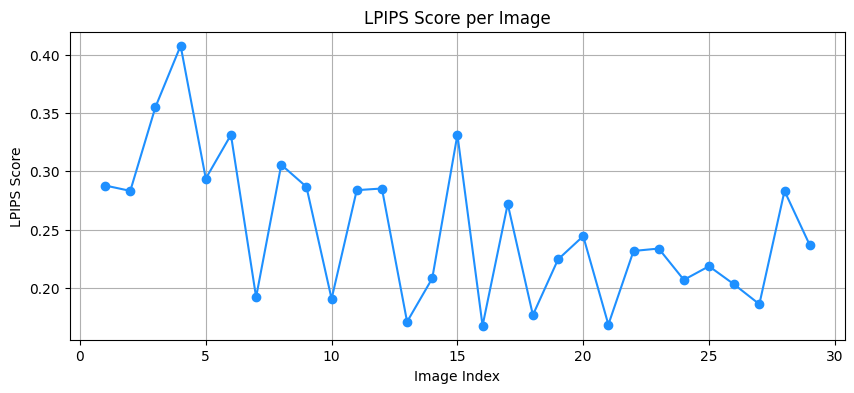

📊 Final FID Score: 269.5910
💫 Average LPIPS Score: 0.2505


In [29]:
# --------- Plotting ---------
x = list(range(1, len(lpips_scores)+1))

# LPIPS Plot
plt.figure(figsize=(10, 4))
plt.plot(x, lpips_scores, marker='o', color='dodgerblue')
plt.title("LPIPS Score per Image")
plt.xlabel("Image Index")
plt.ylabel("LPIPS Score")
plt.grid(True)
plt.show()

# --------- Final Prints ---------
print(f"📊 Final FID Score: {fid_score:.4f}")
print(f"💫 Average LPIPS Score: {np.mean(lpips_scores):.4f}")